In [10]:
url='http://opendap.renci.org:1935/thredds/dodsC/Experiments/Isabel_ex1/ADCIRC/12km/n01/maxele.63.nc'

url =
http://opendap.renci.org:1935/thredds/dodsC/Experiments/Isabel_ex1/ADCIRC/12km/n01/maxele.63.nc

In [11]:
which ncgeodataset

/Users/bblanton/matlab/nctoolbox/cdm/ncgeodataset.m  % ncgeodataset constructor

In [12]:
nc=ncgeodataset(url)

nc = 
  ncgeodataset with properties:

     location: 'http://opendap.renci.org:1935/thredds/dodsC/Experiments/Is...'
       netcdf: [1x1 ucar.nc2.dataset.NetcdfDataset]
    variables: {18x1 cell}

In [13]:
g=ExtractGrid(nc)

g = 
              name: 'nc_inundation_v9.98_msl - 1/22/2014 - Crystal Fulcher...'
                 e: [1230430x3 double]
                 x: [622946x1 double]
                 y: [622946x1 double]
                 z: [622946x1 double]
               bnd: [15756x2 double]
                 A: [1230430x3 double]
                 B: [1230430x3 double]
                A0: [1230430x2 double]
                 T: [1230430x3 double]
                dy: [1230430x3 double]
                dx: [1230430x3 double]
    interiorangles: [1230430x3 double]
             acute: [1230430x1 logical]
                ar: [1230430x1 double]
              ineg: [0x1 double]
                EL: [1230430x3 double]
           triQual: [1230430x1 double]
             xecen: [1230430x1 double]
             yecen: [1230430x1 double]
             zecen: [1230430x1 double]

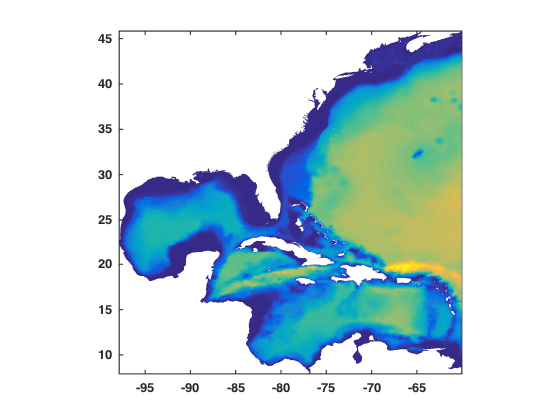

In [17]:
colormesh2d(g,'z');axeq;axtt;set(gca,'FontSize',6)